In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from SDE_schemes import *
from models import *

# Solving SDEs

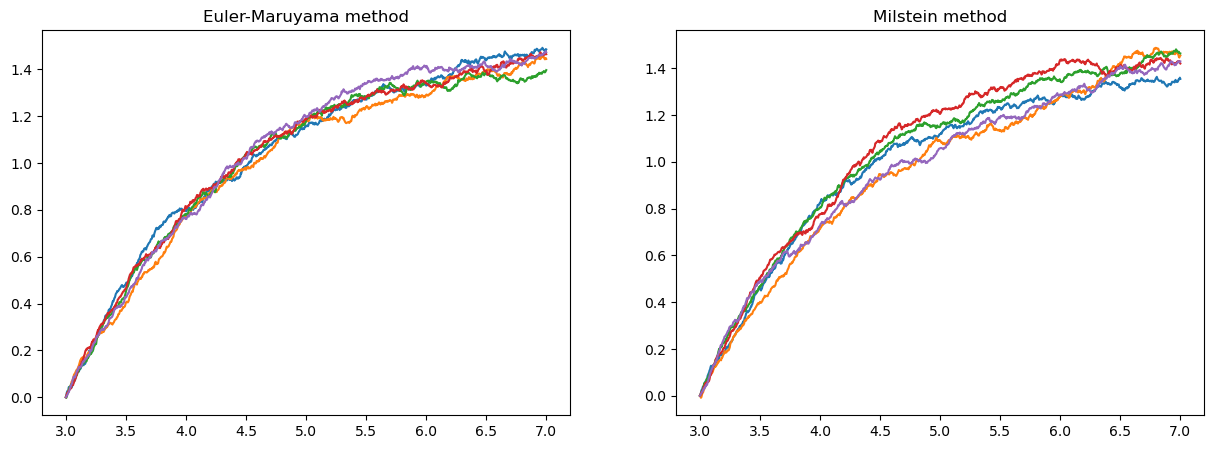

In [19]:
# checking results with wikipedia example - https://pl.wikipedia.org/wiki/Metoda_Eulera-Maruyamy
t0 = 3
tn = 7
N = 1000

def a(x, t):
    return 0.7 * (1.5 - x)

def b(x, t):
    return 0.06

sde = SDE(a, b)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Euler-Maruyama method')
for i in range(5):
    t, x = EulerMaruyamaSolver.performSimulation(sde, 0, t0, tn, N)
    plt.plot(t, x)

#plot 2:
plt.subplot(1, 2, 2)
plt.title('Milstein method')
for i in range(5):
    t, x = MilsteinSolver.performSimulation(sde, 0, t0, tn, N)
    plt.plot(t, x)

plt.show()


# Calibration

## reading data and preprocessing

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/wrcarpenter/Interest-Rate-Models/refs/heads/main/Data/zcbs.csv')
df['Date'] = df['Date'].apply(pd.to_datetime)

df = df.sort_values(by='Date')
df = df.reset_index(drop=True)

df['DaysPassed'] = (df['Date'] - df['Date'][0]).dt.days

df

Date         1         2         3         4         5         6  \
0   2022-10-19  0.997245  0.994006  0.990406  0.986556  0.982548  0.978464   
1   2022-10-20  0.997021  0.993684  0.990071  0.986255  0.982302  0.978266   
2   2022-10-21  0.997046  0.993735  0.990152  0.986373  0.982465  0.978485   
3   2022-10-24  0.997029  0.993663  0.989999  0.986125  0.982120  0.978049   
4   2022-10-25  0.997038  0.993689  0.990047  0.986196  0.982210  0.978154   
..         ...       ...       ...       ...       ...       ...       ...   
342 2024-03-04  0.995419  0.990835  0.986293  0.981831  0.977476  0.973250   
343 2024-03-05  0.995427  0.990853  0.986323  0.981875  0.977538  0.973335   
344 2024-03-06  0.995427  0.990855  0.986328  0.981883  0.977546  0.973341   
345 2024-03-07  0.995419  0.990846  0.986324  0.981889  0.977566  0.973378   
346 2024-03-08  0.995419  0.990844  0.986319  0.981881  0.977558  0.973372   

            7         8         9  ...       352       353       354  \
0    0.974368  0.970310  0.966327  ...  0.298604  0.299035  0.299500   
1    0.974198  0.970136  0.966113  ...  0.291312  0.291720  0.292161   
2    0.974483  0.970497  0.966558  ...  0.281259  0.281669  0.282112   
3    0.973971  0.969933  0.965970  ...  0.274764  0.275096  0.275459   
4    0.974085  0.970049  0.966084  ...  0.285780  0.286166  0.286584   
..        ...       ...       ...  ...       ...       ...       ...   
342  0.969166  0.965231  0.961443  ...  0.277085  0.276992  0.276922   
343  0.969279  0.965378  0.961630  ...  0.284197  0.284155  0.284136   
344  0.969279  0.965368  0.961607  ...  0.287331  0.287195  0.287082   
345  0.969336  0.965446  0.961708  ...  0.285241  0.285091  0.284964   
346  0.969336  0.965456  0.961731  ...  0.284394  0.284212  0.284051   

          355       356       357       358       359       360  DaysPassed  
0    0.299999  0.300533  0.301102  0.301705  0.302344  0.303019           0  
1    0.292635  0.293144  0.293686  0.294262  0.294874  0.295520           1  
2    0.282589  0.283099  0.283642  0.284220  0.284833  0.285480           2  
3    0.275854  0.276280  0.276738  0.277229  0.277753  0.278309           5  
4    0.287036  0.287521  0.288040  0.288593  0.289180  0.289802           6  
..        ...       ...       ...       ...       ...       ...         ...  
342  0.276875  0.276851  0.276850  0.276872  0.276918  0.276988         502  
343  0.284142  0.284173  0.284229  0.284309  0.284415  0.284546         503  
344  0.286991  0.286921  0.286874  0.286849  0.286847  0.286868         504  
345  0.284859  0.284776  0.284716  0.284678  0.284663  0.284672         505  
346  0.283912  0.283794  0.283697  0.283622  0.283568  0.283537         506  

[347 rows x 362 columns]

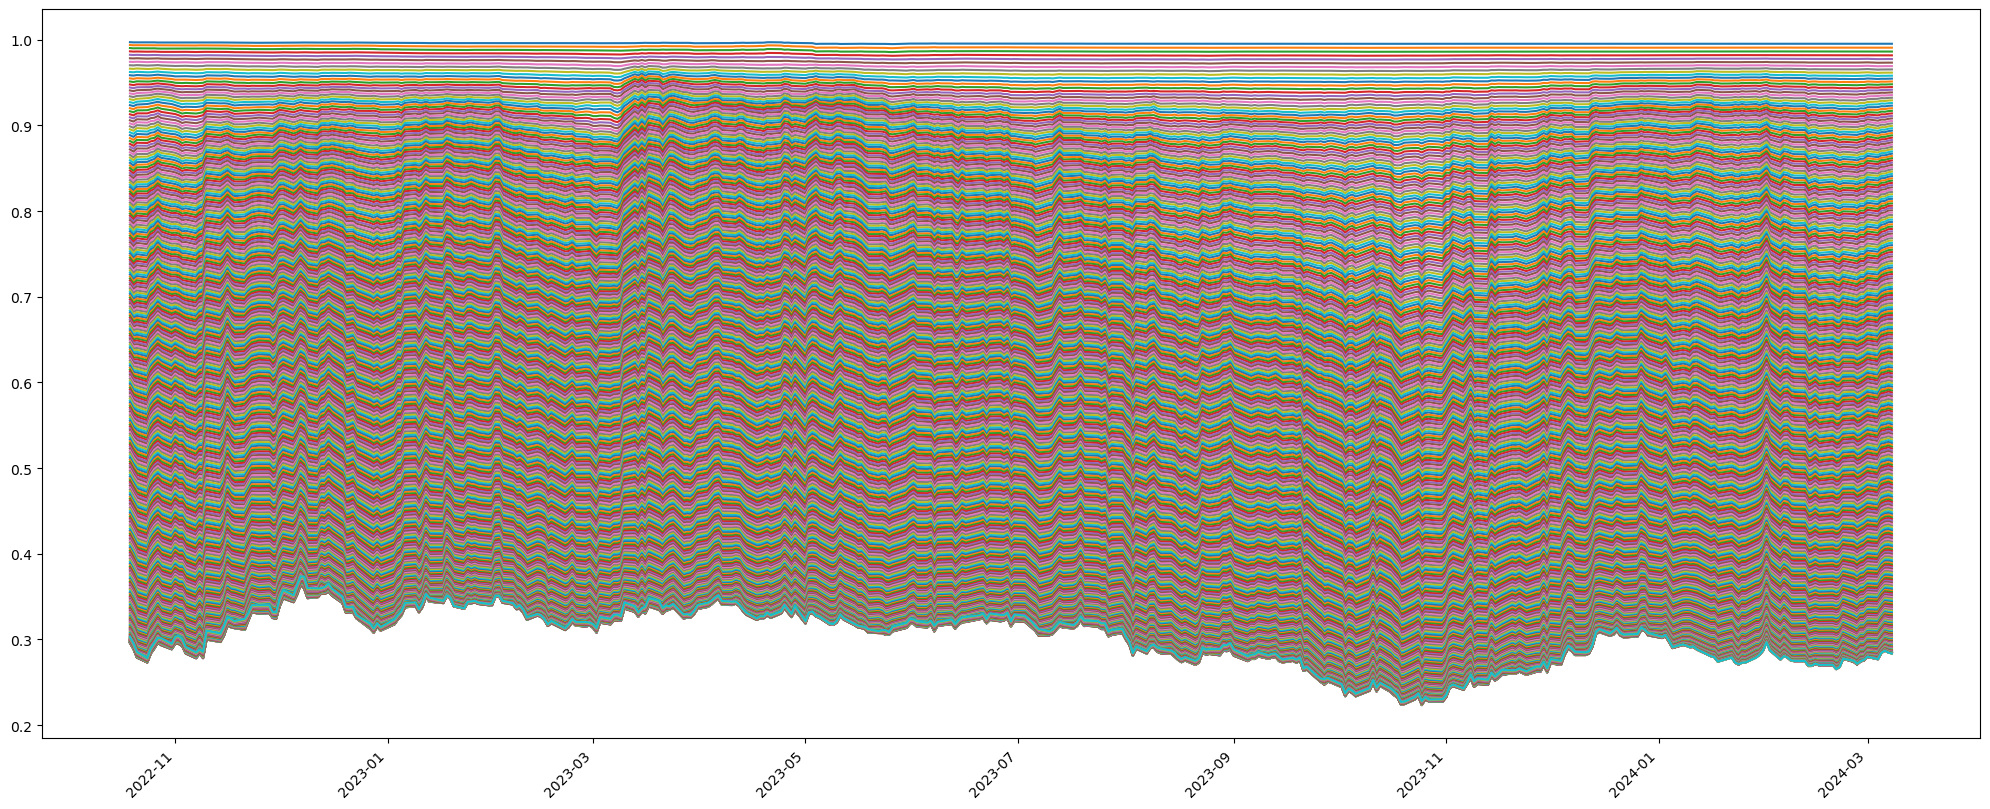

In [46]:
# plotting data
N = 360
dates = df['Date']

plt.figure(figsize=(20, 8))
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

for i in range(1, N+1):
    columnData = df[str(i)]
    plt.plot(dates, columnData, label=f'{i} days')

ylim = plt.gca().get_ylim()
plt.show()

## fitting to columns

0.00620162052478844 0.004751021949319734 0.003099725684173063


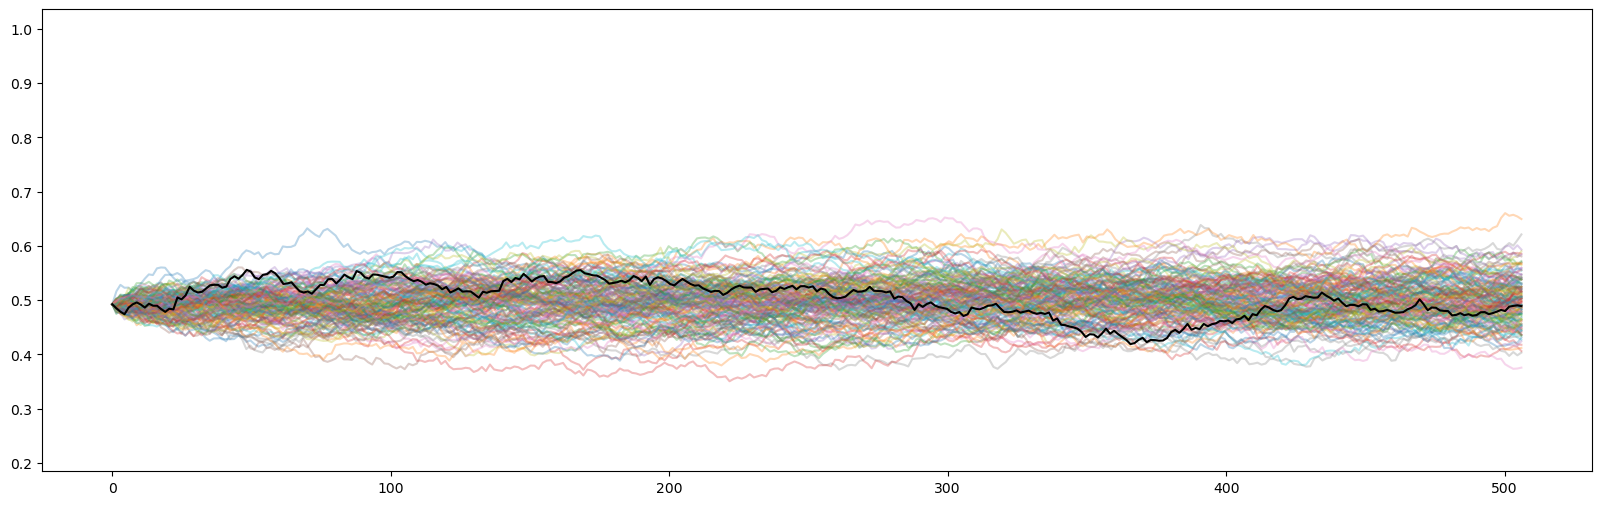

In [50]:
# setting data to fit to
column = '200'
data = df[column]

N = len(data)
t0 = df['DaysPassed'].iloc[0]
T = df['DaysPassed'].iloc[N-1]

# calibrating model
model = VasicekModel()
dt = (T - t0) / N
model.calibrate(data, dt)
r0 = data.iloc[0]
print(model.alpha, model.sigma, model.theta)

plt.figure(figsize=(20, 6))
plt.gca().set_ylim(ylim)

# simulating paths
num_of_simulations = 150
for i in range(num_of_simulations):
    t, x = MilsteinSolver.performSimulation(model.getSDE(), r0, t0, T, N)
    plt.plot(t, x, alpha=0.3)

# plotting data we are estimating
plt.plot(np.linspace(t0, T, N), data, 'k')

plt.show()

## yield curve (fitting to rows)

model parameters:
 0.003898072729448549 0.0004750694866068837 0.0001563217609347163


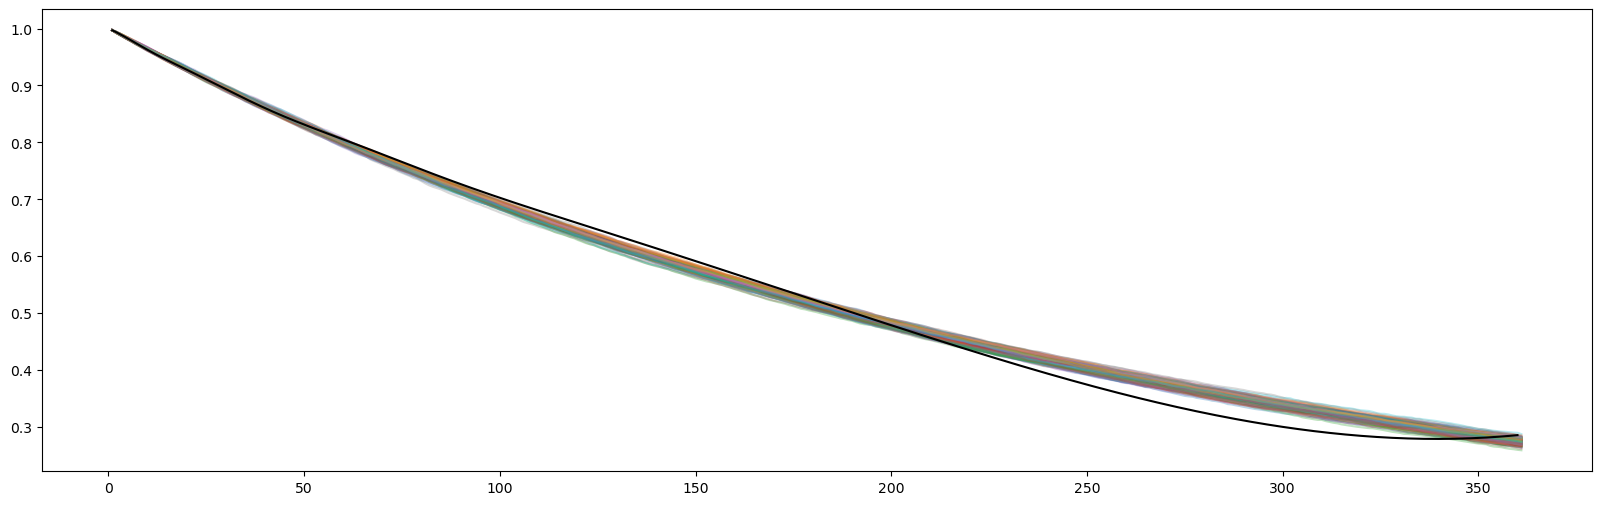

In [9]:
# setting data to fit to
rowIndex = 2
firstMaturity = 1
lastMaturity = 360

columns = [str(i) for i in range(firstMaturity, lastMaturity+1)]
data = df.iloc[rowIndex][columns]

N = lastMaturity - firstMaturity + 1

# calibrating model
model = VasicekModel()
model.calibrate(data, 1)
r0 = data.iloc[0]
print("model parameters:\n", model.alpha, model.sigma, model.theta)

# simulating paths
num_of_simulations = 150
plt.figure(figsize=(20, 6))
for i in range(num_of_simulations):
    t, x = MilsteinSolver.performSimulation(model.getSDE(), r0, firstMaturity, lastMaturity+1, N)
    plt.plot(t, x, alpha=0.3)

# plotting data we are estimating
plt.plot(range(firstMaturity, lastMaturity+1), data, 'k')

plt.show()